In [12]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import statsmodels.api as sm

import scipy.stats as stats
import cartopy.crs as ccrs
import pylab
import tables

sns.set_theme(style="white")
sns.set_style("white")
random.seed(10)


In [13]:
tracks1 = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.h5')
# tracks1.head()
# tracks1.date.values
tracks1.columns



Index(['Dp', 'DpDt', 'DsqP', 'Dx', 'Dy', 'Ege', 'Ely', 'Emg', 'Erg', 'Esp',
       'area', 'centers', 'depth', 'id', 'lat', 'long', 'p_cent', 'p_edge',
       'pid', 'ptid', 'radius', 'time', 'type', 'u', 'uv', 'v', 'x', 'y',
       'sid', 'year', 'mon', 'uid', 'date', 'dDist'],
      dtype='object')

what is the 'uid' here?
UID = UNIQUE IDENTIFIER
Step below, all the identifiers at the time specified were found

In [14]:
pd.unique(tracks1.uid)


array(['202202000', '202202001', '202202002', '202202003', '202202004',
       '202202005', '202202006', '202202007', '202202008', '202202009',
       '202202010', '202202011', '202202012', '202202013', '202202014',
       '202202015', '202202016', '202202017', '202202018', '202202019',
       '202202020', '202202021', '202202022', '202202023', '202202024',
       '202202025', '202202026', '202202027', '202202028', '202202029',
       '202202030', '202202031', '202202032'], dtype=object)


The following track could be the Eunice track in this member, uid = '202202022', also uid = '202202007'. It is longer than one day, gets sufficiently strong and is created in the area that we would expect.


Minimum pressure =  96736.45858827776
Genesis latitude =  59.728563217893175
Genesis longitude =  28.387919663540384


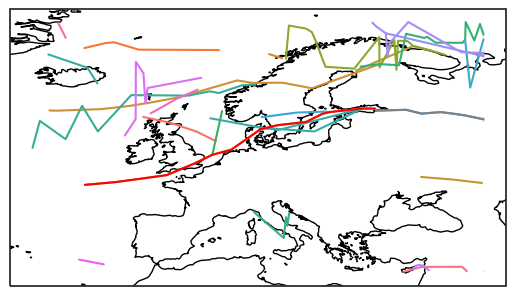

In [28]:

tracks1[tracks1.uid=='202202007'][['uid', 'date', 'lat', 'long', 'p_cent']] 

print('Minimum pressure = ', min(tracks1[tracks1.uid=='202202022'].p_cent))
print('Genesis latitude = ', tracks1[tracks1.uid=='202202022'].lat.values[0])
print('Genesis longitude = ', tracks1[tracks1.uid=='202202022'].long.values[0])


fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))

sns.lineplot(data=tracks1,x='long',y='lat',hue='uid',legend=False)
sns.lineplot(data=tracks1[tracks1.uid == '202202007'],x='long',y='lat',color='red',legend='auto')
sns.lineplot(data=tracks1[tracks1.uid == '202202022'],x='long',y='lat',color='grey',legend=False)
ax.coastlines()


In [27]:
print('Genesis_date =', tracks1[tracks1.uid =='202202007'][['date']])

Genesis_date =                   date
0  2022-02-13 00:00:00
1  2022-02-13 06:00:00
2  2022-02-13 12:00:00
3  2022-02-13 18:00:00
4  2022-02-14 00:00:00
5  2022-02-14 06:00:00
6  2022-02-14 12:00:00
7  2022-02-14 18:00:00
8  2022-02-15 00:00:00
9  2022-02-15 06:00:00
10 2022-02-15 12:00:00
11 2022-02-15 18:00:00
12 2022-02-16 00:00:00
13 2022-02-16 06:00:00
14 2022-02-16 12:00:00
15 2022-02-16 18:00:00
16 2022-02-17 00:00:00


sns.lineplot() surely I should learn about this package

okay, so here we have a consistent red line indicative of the storm eunice

In [1]:
early_date = pd.Timestamp(2022,2,9, 0)
late_date = pd.Timestamp(2022,2,19, 18)

# Filter uid
eunice_ids = [] # fill with those ids that could be Eunice
for id_ in pd.unique(tracks1.uid): 
    # print(id_)
    data_for_id = tracks1[tracks1.uid == id_]
    # print('Genesis data: ', data_for_id.date[0], data_for_id.long[0], data_for_id.lat[0])
    min_pres = min(data_for_id.p_cent) < 99000  # in Pa not hPa 
    gen_lat = (data_for_id.lat[0] > 40) & (data_for_id.lat[0] < 65)
    gen_long = (data_for_id.long [0] > -45) & (data_for_id.long[0] < 0)
    gen_time = ((data_for_id.date[0] >=  early_date) & (data_for_id.date[0] <= late_date))

    # print(min_pres, gen_lat, gen_long, gen_time)
    
    if min_pres & gen_lat & gen_long & gen_time:
        eunice_ids.append(id_)


eunice_ids

NameError: name 'pd' is not defined

the output is a null list here, which is slightly strange



Filter tracks in all members section follows

In [17]:
## Load all members, ensemble i.e current climate
dates = ['10', '14', '16']
cfpf = ['cf', 'pf']

# Initialise empty data frame
tracks_curr = pd.DataFrame({'uid' : [],
                              'date' : [], 
                              'lat' : [], 
                              'long' : [], 
                              'p_cent' : []})
members = np.arange(1,51,1)

for date in dates:
    for c in cfpf:
        if c == 'pf': 
            for member in members:
                tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/ENS/EU025/sfc/'+c+'/1_2022-02-'+date+'_mem'+str(member)+'.h5')
                tracks.uid = tracks.uid.values+'_init'+str(date)+'_mem'+str(member)
                tracks_curr = pd.merge(tracks_curr, 
                                       tracks[['uid', 'date', 'lat', 'long', 'p_cent']], 
                                       how = 'outer')
        else: 
            tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/ENS/EU025/sfc/'+c+'/1_2022-02-'+date+'.h5')
            tracks.uid = tracks.uid.values+'_init'+str(date)+'_memCF'
            tracks_curr = pd.merge(tracks_curr, 
                                   tracks[['uid', 'date', 'lat', 'long', 'p_cent']], 
                                   how = 'outer')

In [18]:
early_date = pd.Timestamp(2022,2,16, 0)
late_date =  pd.Timestamp(2022,2,18, 18)

# Filter uid
eunice_ids_curr = [] # fill with those ids that could be Eunice
for id_ in pd.unique(tracks_curr.uid): 
    data_for_id = tracks_curr[tracks_curr.uid == id_]
    min_pres = min(data_for_id.p_cent) < 99000  # in Pa not hPa 
    gen_lat = (data_for_id.lat.values[0] > 40) & (data_for_id.lat.values[0] < 65)
    gen_long = (data_for_id.long.values[0] > -45) & (data_for_id.long.values[0] < 0)
    gen_time = ((data_for_id.date.values[0] >=  early_date) & (data_for_id.date.values[0] < late_date))

    
    if min_pres & gen_lat & gen_long & gen_time:
        eunice_ids_curr.append(id_)


In [19]:
## Load all members for experiments

experiments = ['pi', 'incr']
cfpf = ['cf', 'pf']

# Initialise empty data frame
tracks_pi = pd.DataFrame({'uid' : [],
                          'date' : [], 
                          'lat' : [], 
                          'long' : [], 
                          'p_cent' : []})

tracks_incr = tracks_pi.copy()

dates = {'pi' : ['b2nn_2022-02-14', 'b2ns_2022-02-16', 'b2nq_2022-02-10'], 
               'incr' : ['b2no_2022-02-14', 'b2nr_2022-02-10', 'b2nt_2022-02-16']}  # members for incr and pi runs
members = np.arange(1,51,1)
for exp in experiments:
    for date in dates[exp]:
        for c in cfpf:
            if c == 'pf': 
                for member in members:
                    tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/EXP/'+exp+'/EU025/sfc/'+c+'/'+date+'_mem'+str(member)+'.h5')
                    tracks.uid = tracks.uid.values+'_init'+str(date)+'_mem'+str(member)
                    if exp == 'pi':
                        tracks_pi = pd.merge(tracks_pi, 
                                            tracks[['uid', 'date', 'lat', 'long', 'p_cent']], 
                                            how = 'outer')
                    elif exp == 'incr':
                        tracks_incr = pd.merge(tracks_incr, 
                                            tracks[['uid', 'date', 'lat', 'long', 'p_cent']], 
                                            how = 'outer')
            else: 
                tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/MED-R/EXP/'+exp+'/EU025/sfc/'+c+'/'+date+'.h5')
                tracks.uid = tracks.uid.values+'_init'+str(date)+'_memCF'
                if exp == 'pi':
                    tracks_pi = pd.merge(tracks_pi, 
                                        tracks[['uid', 'date', 'lat', 'long', 'p_cent']], 
                                        how = 'outer')
                elif exp == 'incr':
                    tracks_pi = pd.merge(tracks_incr, 
                                        tracks[['uid', 'date', 'lat', 'long', 'p_cent']], 
                                        how = 'outer')


In [20]:
tracks.uid

0    202202000_initb2nt_2022-02-16_mem50
1    202202000_initb2nt_2022-02-16_mem50
2    202202000_initb2nt_2022-02-16_mem50
3    202202000_initb2nt_2022-02-16_mem50
4    202202000_initb2nt_2022-02-16_mem50
                    ...                 
6    202202017_initb2nt_2022-02-16_mem50
0    202202018_initb2nt_2022-02-16_mem50
1    202202018_initb2nt_2022-02-16_mem50
0    202202019_initb2nt_2022-02-16_mem50
1    202202019_initb2nt_2022-02-16_mem50
Name: uid, Length: 78, dtype: object

In [22]:
tracks_pi

,uid,date,lat,long,p_cent
0,202202000_initb2no_2022-02-14_mem1,2022-02-14 00:00:00,35.782617,31.470412,101686.713372
1,202202000_initb2no_2022-02-14_mem1,2022-02-14 03:00:00,35.810895,32.357848,NaN
2,202202001_initb2no_2022-02-14_mem1,2022-02-14 00:00:00,35.058364,38.450908,101618.786552
3,202202001_initb2no_2022-02-14_mem1,2022-02-14 03:00:00,37.498508,39.432155,NaN
4,202202002_initb2no_2022-02-14_mem1,2022-02-14 00:00:00,34.730266,45.000000,101437.080489
...,...,...,...,...,...
23547,202202018_initb2nt_2022-02-16_memCF,2022-02-19 15:00:00,33.134737,-4.127592,101619.754126
23548,202202018_initb2nt_2022-02-16_memCF,2022-02-19 18:00:00,33.134737,-4.127592,101808.256205
23549,202202018_initb2nt_2022-02-16_memCF,2022-02-19 21:00:00,33.134737,-4.127592,NaN
23550,202202019_initb2nt_2022-02-16_memCF,2022-02-19 18:00:00,61.129346,35.746595,97642.453751
